In [ ]:
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image as PILImage
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Data Acquisition

For this assignment, we provide two methods for you to access the dataset:

**Method 1: Direct Download for Local Usage**  
You can directly download the dataset from the following Google Drive link: [Dataset Download](https://drive.google.com/file/d/1PSRdWIotycCMlKABQJ0hADSPUmJB_4dH/view?usp=sharing). After downloading, you should extract it into `data/` on your local machine. This method is suitable for those who wish to run the assignment on their own computers.

**Method 2: Google Colab Setup**  
For those who prefer using Google Colab, you can download the dataset directly onto your Colab runtime. Alternatively, if your Google Drive storage permits, you can also save and extract the dataset there. This approach ensures data persistence even if the Colab session is interrupted.

The dataset contains approximately 20K training images and 100 validation images, each with multiple captions/tags. For this assignment, we will only focus on the tags and disregard the captions.

Regarding the second question of the assignment, the dataset also includes a JSON file that maps the ImageNet labels to the category names.

The code provided below serves as an example of how to load the data using Google Colab. Make sure to follow the instructions and adapt them if necessary.

[Here you can place the code you mentioned previously, which demonstrates how to download and extract the data in Colab.]


In [ ]:
# 1. Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

# 2. Use gdown tool to download from Google Drive link
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1PSRdWIotycCMlKABQJ0hADSPUmJB_4dH'
output = '/content/drive/MyDrive/DCAI_lab/Lab-A2/data.zip'
gdown.download(url, output, quiet=False)

# 3. Use zipfile to decompress the downloaded content
import zipfile
import os

# Extract files to Colab's local "data" directory
local_data_dir = '/content/data'
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(local_data_dir)

print("Data extracted to", local_data_dir)

Mounted at /content/drive
Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1PSRdWIotycCMlKABQJ0hADSPUmJB_4dH 



Data extracted to /content/data


In [ ]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
])
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = PILImage.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var


load_image('data/data_sampled/train2014/COCO_train2014_000000000009.jpg')

tensor([[[[0.0039, 0.0078, 0.0039,  ..., 0.0471, 0.0471, 0.0314],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0353, 0.0392],
          [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0510],
          ...,
          [0.7137, 0.7294, 0.7137,  ..., 0.1686, 0.1843, 0.1686],
          [0.7059, 0.6902, 0.6863,  ..., 0.1765, 0.1804, 0.2039],
          [0.6784, 0.6667, 0.6706,  ..., 0.1922, 0.2157, 0.2275]],

         [[0.1490, 0.1490, 0.1412,  ..., 0.0039, 0.0039, 0.0039],
          [0.1451, 0.1412, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          [0.1412, 0.1373, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.4392, 0.4667, 0.4549,  ..., 0.2588, 0.2745, 0.2863],
          [0.4353, 0.4235, 0.4196,  ..., 0.2745, 0.2980, 0.3137],
          [0.4118, 0.4000, 0.4000,  ..., 0.3020, 0.3176, 0.3020]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.1451, 0.1412, 0.1333],
          [0.5255, 0.5333, 0.5373,  ..., 0.1725, 0.1451, 0.1412],
          [0.5373, 0.5490, 0.5451,  ..., 0

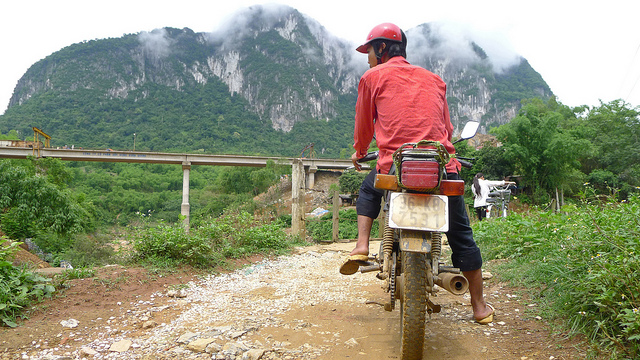

In [ ]:
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open('data/data_sampled/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 20K training images.
mscoco_train = json.load(open('data/data_sampled/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/data_sampled/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open('data/data_sampled/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/data_sampled/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

from IPython.display import Image, display
display(Image(filename='data/data_sampled/val2014/COCO_val2014_000000391895.jpg'))

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/data_sampled/val2014/COCO_val2014_000000391895.jpg`. The image is shown above.

The following code determines the category labels for this image.

In [ ]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)

# Remove the last layer (classifier) from the VGG model
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-1])

# Set the model to evaluation mode (disables dropout)
vgg_model.eval()

# Print the modified VGG model
print(vgg_model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 179MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained VGG model and move it to the GPU
vgg_model = models.vgg16(pretrained=True).cuda()

# Create an instance of the Softmax layer
softmax = nn.Softmax(dim=1)

for image_id in val_ids[:10]:
    # Display the image.
    image_path = val_id_to_file[image_id]
    display(Image(filename=image_path))

    # Print all of the category labels for this image.
    category_labels = [category_to_name[cat_id] for cat_id in val_id_to_categories[image_id]]
    print("True labels:", ", ".join(category_labels))

    # Load/preprocess the image and move it to the GPU
    img = load_image(val_id_to_file[image_id]).cuda()

    # Run the image through the model and softmax.
    output = vgg_model(img)
    label_likelihoods = softmax(output).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    top5_likelihoods, top5_indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions for this image.
    print("Top 5 Predictions:")
    for i in range(5):
        category_idx = top5_indices[i].item()
        likelihood = top5_likelihoods[i].item()
        if category_idx < len(imagenet_categories):
            category_name = imagenet_categories[category_idx]
            print(f"{category_name}: {likelihood * 100:.2f}%")
        else:
            print(f"Category index {category_idx} is out of range.")

    print()  # Print an empty line to separate results for different images


Output hidden; open in https://colab.research.google.com to view.

# Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [ ]:
# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)

# Remove the last layer (classifier) from the VGG model
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-1])

# Set the model to evaluation mode (disables dropout)
vgg_model.eval()

# Print the modified VGG model
print(vgg_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# First we vectorize all of the features of training images and write the results to a file.
import concurrent.futures
# -- Your code goes here --
# vectorise training image features

if not os.path.exists('outputs'):
    os.makedirs('outputs')
output_file_path = 'outputs/training_vectors.npy'

training_vectors = []
# feature_extractor = feature_extractor.cuda()

for image_id in train_ids:
    # Load/preprocess the image.
    image_path = train_id_to_file[image_id]
    img = load_image(image_path).cuda()
    with torch.no_grad():
      vgg_model = vgg_model.to(img.device)
      # Run the image through the feature extractor.
      training_vectors.append(vgg_model(img).cpu().numpy())

# Convert the list of feature vectors to a NumPy array
training_vectors = np.array(training_vectors)

np.save(open(output_file_path, 'wb+'), training_vectors)
np.save('/content/drive/MyDrive/DCAI_lab/Lab-A2/training_vectors.npy', training_vectors)


In [ ]:
# Next we vectorize all of the features of validation images and write the results to a file.

# -- Your code goes here --
# vectorise features
output_file_path2 = 'outputs/validation_vectors.npy'

validation_vectors = []

for image_id in val_ids:
    # Load/preprocess the image.
    image_path = val_id_to_file[image_id]
    img = load_image(image_path).cuda()
    with torch.no_grad():
      # Run the image through the feature extractor.
      features = vgg_model(img).detach().cpu().numpy()


    # Append the features to the validation_vectors list.
    validation_vectors.append(features)

# Convert the list of feature vectors to a NumPy array
validation_vectors = np.array(validation_vectors)

# Save the NumPy array to the specified file
np.save(open(output_file_path2, 'wb+'), validation_vectors)
np.save('/content/drive/MyDrive/DCAI_lab/Lab-A2/validation_vectors.npy', validation_vectors)


# Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

In [ ]:
import numpy as np

# Load the generated vectors for training and validation images
training_vectors = np.load('outputs/training_vectors.npy')
validation_vectors = np.load('outputs/validation_vectors.npy')

# Reshape the training_vectors to (20000, 25088) and validation_vectors to (100, 25088)
training_vectors = training_vectors.reshape(training_vectors.shape[0], -1)
validation_vectors = validation_vectors.reshape(validation_vectors.shape[0], -1)

# Iterate through the first 10 validation images
for i, val_image_vector in enumerate(validation_vectors[:10]):
    # Calculate the Euclidean distances between the validation vector and all training vectors
    distances = [np.linalg.norm(val_image_vector - train_image_vector) for train_image_vector in training_vectors]

    # Find the index of the closest training image
    closest_training_idx = np.argmin(distances)

    # Get the IDs of the validation and closest training images
    val_image_id = val_ids[i]
    closest_training_id = train_ids[closest_training_idx]

    print(f"Closest training image for validation image {val_image_id} is {closest_training_id}")

    # Load and display both images
    val_image_path = val_id_to_file[val_image_id]
    closest_training_image_path = train_id_to_file[closest_training_id]

    display(Image(filename=val_image_path))
    display(Image(filename=closest_training_image_path))


Output hidden; open in https://colab.research.google.com to view.

# Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO.

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512.

#####1. set class

In [ ]:
training_vectors = np.load('/content/drive/MyDrive/DCAI_lab/Lab-A2/training_vectors.npy')
validation_vectors = np.load('/content/drive/MyDrive/DCAI_lab/Lab-A2/validation_vectors.npy')
training_vectors = np.squeeze(training_vectors)
validation_vectors = np.squeeze(validation_vectors)


In [ ]:
# First we construct a class for the model
# -- Your code goes here --
class MultiLabelClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiLabelClassificationModel, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass
        x = self.hidden_layer(x)
        x = self.sigmoid(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

# Define the dimensions
input_dim = 4096  # Dimension of input features
hidden_dim = 512   # Dimension of the hidden layer
output_dim = 80   # Number of categories in MSCOCO

# Create an instance of the model
model = MultiLabelClassificationModel(input_dim, hidden_dim, output_dim)

# Move the model to the GPU if available
device = torch.device("cuda")
model.to(device)

# Print the model architecture
print(model)


MultiLabelClassificationModel(
  (hidden_layer): Linear(in_features=4096, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=80, bias=True)
  (sigmoid): Sigmoid()
)


#####2. change training set's categories to indices and remove duplicates in training vectors

In [ ]:
# changing ground truth into binary vectors (column 0-80 = category 0th-79th)
# change integer categories from range 1-90 (categorical variable) into 1-80
train_id_to_indices = {}

# Map each category in train_id_to_categories to its index
for image_id, categories in train_id_to_categories.items(): # 20000 samples
    category_indices = [category_to_idx[category] for category in categories]
    train_id_to_indices[image_id] = category_indices
    # train_id_to_indices: dict with 20000 samples with correct 1-80 cat

# map as vector
all_categories = range(1, 81)

# Convert the dictionary into binary vectors
train_binary_truth_vectors = {}
for image_id, categories in train_id_to_indices.items():
    binary_vector = [1 if category in categories else 0 for category in all_categories]
    train_binary_truth_vectors[image_id] = binary_vector

# convert dict to tensor
train_binary_truth_vectors = np.array(list(train_binary_truth_vectors.values()))
train_binary_truth_vectors = torch.tensor(train_binary_truth_vectors, dtype=torch.float)

print("Training Vectors Shape:", training_vectors.shape)
print("Binary Truth Vectors Shape:", train_binary_truth_vectors.shape)
#save
np.save('/content/drive/MyDrive/DCAI_lab/Lab-A2/train_binary_truth_vectors.npy', train_binary_truth_vectors)

len(train_id_to_categories)

Training Vectors Shape: (20000, 4096)
Binary Truth Vectors Shape: torch.Size([19836, 80])


19836

In [ ]:
train_vector_ind = [(ind, vec) for vec, ind in zip(training_vectors, train_ids)]

clean_train_vector = {}

for ind, vector in train_vector_ind:
    # Check if the index ID is in train_id_to_categories
    if ind in train_id_to_categories:
        # If the index ID is in train_id_to_categories, keep the vector
        clean_train_vector[ind] = vector

clean_train_vectors = list(clean_train_vector.values())
# need a save
np.save('/content/drive/MyDrive/DCAI_lab/Lab-A2/clean_train_vectors.npy', clean_train_vectors)
clean_train_vectors = torch.tensor(np.array(clean_train_vectors))

In [ ]:
print(training_vectors.shape)
print(clean_train_vectors.shape) # in good dim
print(train_binary_truth_vectors.shape)


(20000, 4096)
torch.Size([19836, 4096])
torch.Size([19836, 80])


##### 3. build model and model training

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train(model, learning_rate=0.001, batch_size=100, epochs=5):
    """
    Training function which takes as input a model, a learning rate, and a batch size.

    After completing a full pass over the data, the function exits, and the input model will be trained.
    """
    # Parameters
    criterion = nn.MSELoss()  # Change the loss function to MSE
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training vectors
    dataset = TensorDataset(clean_train_vectors, train_binary_truth_vectors)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {total_loss / len(dataloader)}")

# Define the dimensions
input_dim = 4096
hidden_dim = 512
output_dim = 80

# Create an instance of the model and move it to the GPU if available
model = MultiLabelClassificationModel(input_dim, hidden_dim, output_dim).to(device)

# Train the model with MSE loss
train(model)


Epoch [1/5] Loss: 0.03172455370501058
Epoch [2/5] Loss: 0.02917602547355483
Epoch [3/5] Loss: 0.029241821251285435
Epoch [4/5] Loss: 0.029206462766057883
Epoch [5/5] Loss: 0.029273471453381543


In [ ]:
# save model
dir_path = '/content/drive/MyDrive/DCAI_lab/Lab-A2/'

os.makedirs(dir_path, exist_ok=True)

torch.save(model.state_dict(), '/content/drive/MyDrive/DCAI_lab/Lab-A2/model.pth')


##### 4. change validation to indices and remove duplicates in validation vector

In [ ]:
# Test the accuracy
# -- Your code goes here --

# process validation  indices
# Map each category in val_id_to_categories to its index
val_id_to_indices = {}
for image_id, categories in val_id_to_categories.items():
    val_id_to_indices[image_id] = [category_to_idx[category] for category in categories]


# Convert the dictionary into binary vectors for validation
val_binary_truth_vectors = {}
for image_id, categories in val_id_to_indices.items():
    binary_vector = [1 if category in categories else 0 for category in all_categories]
    val_binary_truth_vectors[image_id] = binary_vector

# Convert the validation binary truth vectors to a tensor
val_binary_truth_vectors = np.array(list(val_binary_truth_vectors.values()))
np.save('/content/drive/MyDrive/DCAI_lab/Lab-A2/val_binary_truth_vectors.npy',
        val_binary_truth_vectors)
val_binary_truth_vectors = torch.tensor(val_binary_truth_vectors, dtype=torch.float)

print("Validation Binary Truth Vectors Shape:", val_binary_truth_vectors.shape)

Validation Binary Truth Vectors Shape: torch.Size([99, 80])


In [ ]:
val_vector_ind = [(ind, vec) for vec, ind in zip(validation_vectors, val_ids)]

clean_validation_vector = {}

for ind, vector in val_vector_ind:
    # Check if the index ID is in val_id_to_indices
    if ind in val_id_to_indices:
        # If the index ID is in val_id_to_indices, keep the vector
        clean_validation_vector[ind] = vector

# Convert the dictionary values (cleaned vectors) to a list
clean_validation_vectors = list(clean_validation_vector.values())

# Save the cleaned validation vectors to a file
np.save('/content/drive/MyDrive/DCAI_lab/Lab-A2/clean_validation_vectors.npy', clean_validation_vectors)

# Convert the cleaned validation vectors to a PyTorch tensor if needed
clean_validation_vectors = np.array(clean_validation_vectors)
print("Validation Binary Truth Vectors Shape:", val_binary_truth_vectors.shape)
print("Validation Binary Truth Vectors Shape:", val_binary_truth_vectors.shape)

Validation Binary Truth Vectors Shape: torch.Size([99, 80])
Validation Binary Truth Vectors Shape: torch.Size([99, 80])


In [ ]:
# Test
# -- Your code goes here --
# Test the accuracy
# -- Your code goes here --

# Create a dictionary to map each validation image's ID to an 80-dimensional binary vector
validation_binary_truth_vectors = {}

# Map each category in val_id_to_categories to its index
validation_id_to_indices = {}
for image_id, categories in val_id_to_categories.items():
    category_indices = [category_to_idx[category] for category in categories]
    validation_id_to_indices[image_id] = category_indices

# Create an array to represent all the 80 categories
all_categories = range(1, 81)

for image_id, categories in validation_id_to_indices.items():
    binary_vector = [1 if category in categories else 0 for category in all_categories]
    validation_binary_truth_vectors[image_id] = binary_vector

# Convert the dictionary of binary vectors into a NumPy array
validation_binary_truth_array = np.array(list(validation_binary_truth_vectors.values()))

# Convert the NumPy array into a PyTorch tensor
validation_binary_truth_tensor = torch.tensor(validation_binary_truth_array, dtype=torch.float).to(device)


In [ ]:
#deploy model
model.eval()  # Set the model to evaluation mode
validation_vectors_tensor = torch.tensor(clean_validation_vectors, dtype=torch.float).to(device)
# Forward pass using the validation vectors
with torch.no_grad():
    validation_predictions = model(validation_vectors_tensor)

# Calculate accuracy
threshold = 0.5
binary_predictions = (validation_predictions > threshold).int()

# Convert validation_binary_truth_tensor to integers
validation_binary_truth_tensor = validation_binary_truth_tensor.int()  # Ensure the same data type

# Debug print statements
print("Shapes:")
print("binary_predictions shape:", binary_predictions.shape)
print("validation_binary_truth_tensor shape:", validation_binary_truth_tensor.shape)
print("Sample values:")
print("binary_predictions[0]:", binary_predictions[0])
print("validation_binary_truth_tensor[0]:", validation_binary_truth_tensor[0])

accuracy = torch.sum(binary_predictions == validation_binary_truth_tensor).item() / (validation_binary_truth_tensor.shape[0] * validation_binary_truth_tensor.shape[1])

print(f'Validation Accuracy: {accuracy:.3%}')



Shapes:
binary_predictions shape: torch.Size([99, 80])
validation_binary_truth_tensor shape: torch.Size([99, 80])
Sample values:
binary_predictions[0]: tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0', dtype=torch.int32)
validation_binary_truth_tensor[0]: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
Validation Accuracy: 42.260%


# End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing.

In [ ]:
import torch.nn.functional as F

class MultiLabelClassificationModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiLabelClassificationModel2, self).__init__()
        self.vgg_model = models.vgg16(pretrained=True)
        self.vgg_model.classifier[6] = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.vgg_model(x) # rem not to add features

# Define the dimensions
input_dim = 4096  # Dimension of input features
hidden_dim = 512   # Dimension of the hidden layer
output_dim = 80   # Number of categories in MSCOCO

# Create an instance of the model
model2 = MultiLabelClassificationModel2(input_dim, hidden_dim, output_dim)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Print the model architecture
print(model2)


MultiLabelClassificationModel2(
  (vgg_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU

In [ ]:
# prep for 19836 train_ids
selected_train_ids = []  # Initialize an empty list to store the names

for name, values in train_id_to_categories.items():
    # Add the name to the selected_train_ids list
    selected_train_ids.append(name)

In [ ]:
import torch.optim as optim

def train2(model2, learning_rate=0.001, batch_size=50, epochs=5):
    # Define the loss function and the optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

    # Create a dataset and a dataloader
    # due to having not enough RAM , I will put 1000 images here for now.
    image_paths = [train_id_to_file[image_id] for image_id in selected_train_ids[:1000]]
    image_tensors = [load_image(image_path).cuda() for image_path in image_paths]
    image_tensors = torch.stack(image_tensors).squeeze(1)
    # print(torch.cat(image_tensors).shape)

    dataset = TensorDataset(image_tensors, train_binary_truth_vectors[:1000])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        model2.train()
        total_loss = 0.0

        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model2(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {total_loss / len(dataloader)}")

# Create an instance of the model and move it to the GPU if available
model2 = MultiLabelClassificationModel2(input_dim, hidden_dim, output_dim).to(device)

# Finally, train the model
train2(model2)


Epoch [1/5] Loss: 0.05931518748402596
Epoch [2/5] Loss: 0.043175001814961436
Epoch [3/5] Loss: 0.043112502247095105
Epoch [4/5] Loss: 0.04305000174790621
Epoch [5/5] Loss: 0.0430750023573637


In [ ]:
torch.save(model2.state_dict(), '/content/drive/MyDrive/DCAI_lab/Lab-A2/model2.pth')


In [ ]:
# prep for val_ids
selected_val_ids = []  # Initialize an empty list to store the names

for name, values in val_id_to_categories.items():
    # Add the name to the selected_val_ids list
    selected_val_ids.append(name)

# Use validation IDs (val_id) instead of training IDs (train_id)
image_paths = [val_id_to_file[image_id] for image_id in selected_val_ids]
image_tensors = [load_image(image_path).cuda() for image_path in image_paths]
image_tensors = torch.stack(image_tensors).squeeze(1)

In [ ]:
image_tensors.shape

torch.Size([99, 3, 224, 224])

In [ ]:
# evaluate validation set
model2.eval()  # Set the model to evaluation mode

# Forward pass using the validation vectors
with torch.no_grad():
    validation_predictions2 = model2(image_tensors)

# Calculate accuracy
threshold = 0.5
validation_predictions2 = (validation_predictions2 > threshold).int()

# Convert validation_binary_truth_tensor to integers
validation_binary_truth_tensor = validation_binary_truth_tensor.int()  # Ensure the same data type

# Debug print statements
print("Shapes:")
print("binary_predictions shape:", validation_predictions2.shape)
print("validation_binary_truth_tensor shape:", validation_binary_truth_tensor.shape)
print("Sample values:")
print("binary_predictions[0]:", validation_predictions2[0])
print("validation_binary_truth_tensor[0]:", validation_binary_truth_tensor[0])

accuracy = torch.sum(validation_predictions2 == validation_binary_truth_tensor).item() / (validation_binary_truth_tensor.shape[0] * validation_binary_truth_tensor.shape[1])

print(f'Validation Accuracy: {accuracy:.3%}')




Shapes:
binary_predictions shape: torch.Size([99, 80])
validation_binary_truth_tensor shape: torch.Size([99, 80])
Sample values:
binary_predictions[0]: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
validation_binary_truth_tensor[0]: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
Validation Accuracy: 93.851%


# Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size. 

In [ ]:
import itertools

# Define hyperparameters to search grid
learning_rates = [0.001, 0.01 0.1] # due to RAM limit, i can only test a limited number of parameters
batch_sizes = [50,100,200]

# Initialize variables to store the best combination and its accuracy
best_lr = None
best_batch_size = None
best_accuracy = 0.0

# Grid search loop
for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    print(f"Training with Learning Rate: {lr}, Batch Size: {batch_size}")

    # Create a new model for each combination
    model2 = MultiLabelClassificationModel2(input_dim, hidden_dim, output_dim)

    # Define the optimizer with the current learning rate
    optimizer = optim.Adam(model2.parameters(), lr=lr)

    # Move the model to the same device as validation data
    model2.to(device)

    # Train the model (use your training code, but with different hyperparameters)
    train2(model2, learning_rate=lr, batch_size=batch_size, epochs=2) # sorry i can only run a few since my ram and gpu is <1

    # Perform validation
    model2.eval()
    with torch.no_grad():
        validation_predictions = model2(image_tensors)
    threshold = 0.5
    binary_predictions = (validation_predictions > threshold).int()

    # Calculate the accuracy
    accuracy = torch.sum(binary_predictions == validation_binary_truth_tensor).item() / (validation_binary_truth_tensor.shape[0] * validation_binary_truth_tensor.shape[1])


    # Check if the current combination is better than the previous best
    if accuracy > best_accuracy:
        best_lr = lr
        best_batch_size = batch_size
        best_accuracy = accuracy

    # Print accuracy for the current combination
    print(f'Validation Accuracy with LR={lr}, Batch Size={batch_size}: {accuracy:.2%}')

# Print the best combination
print(f'Best Learning Rate: {best_lr}')
print(f'Best Batch Size: {best_batch_size}')
print(f'Best Validation Accuracy: {best_accuracy:.2%}')


Training with Learning Rate: 0.001, Batch Size: 50
Epoch [1/2] Loss: 0.06249136384576559
Epoch [2/2] Loss: 0.04061250202357769
Validation Accuracy with LR=0.001, Batch Size=50: 94.92%
Training with Learning Rate: 0.001, Batch Size: 100


OutOfMemoryError: ignored